In [19]:
import os
import shutil
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image 


In [20]:
import os
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
import pandas as pd
import numpy as np

In [21]:
# Split dataset into train and val
def split_dataset(source_dir, target_dir, train_ratio=0.8):
    classes = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

    for cls in classes:
        cls_source = os.path.join(source_dir, cls)
        images = [f for f in os.listdir(cls_source) if os.path.isfile(os.path.join(cls_source, f))]
        random.shuffle(images)

        train_count = int(len(images) * train_ratio)
        train_images = images[:train_count]
        val_images = images[train_count:]

        # Create folder for train and vals
        train_cls_dir = os.path.join(target_dir, 'train', cls)
        val_cls_dir = os.path.join(target_dir, 'val', cls)
        os.makedirs(train_cls_dir, exist_ok=True)
        os.makedirs(val_cls_dir, exist_ok=True)

        # train data
        for i in train_images:
            shutil.copy(os.path.join(cls_source, i), os.path.join(train_cls_dir, i))

        # val data 
        for i in val_images:
            shutil.copy(os.path.join(cls_source, i), os.path.join(val_cls_dir, i))

        print(f"Class '{cls}': {len(train_images)} train, {len(val_images)} val")

In [22]:
# Dataset path
path = "./Waste_Classification_Dataset"
list_dir = os.listdir(path)   # tránh đặt tên biến trùng với hàm built-in list

class_names = []
class_counts = []

for folder_name in list_dir:
    full_folder_path = os.path.join(path, folder_name)

    if os.path.isdir(full_folder_path):
        file_list = os.listdir(full_folder_path)
        class_names.append(folder_name)
        class_counts.append(len(file_list))
        print(f"There are {len(file_list)} {folder_name} images.")


There are 2283 Metal images.
There are 4424 Miscellaneous images.
There are 2767 Paper images.
There are 6807 Plastic images.


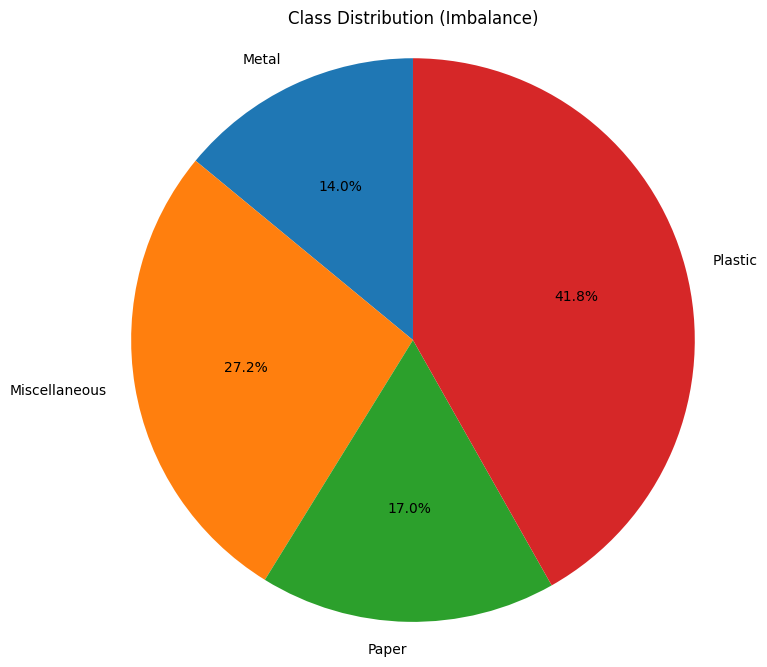

In [23]:
plt.figure(figsize=(8, 8))
plt.pie(
    class_counts,
    labels=class_names,
    autopct='%1.1f%%',
    startangle=90
)
plt.title("Class Distribution (Imbalance)")
plt.axis("equal")  # để tròn đều
plt.show()

In [24]:
ext_counter = Counter()

for folder_name in os.listdir(path):
    full_folder_path = os.path.join(path, folder_name)
    if os.path.isdir(full_folder_path):
        for file in os.listdir(full_folder_path):
            ext = os.path.splitext(file)[-1].lower()
            ext_counter[ext] += 1

print("File extensions distribution:", ext_counter)


File extensions distribution: Counter({'.jpg': 16281})


Min size: 8.50 KB
Max size: 106.35 KB
Avg size: 30.09 KB


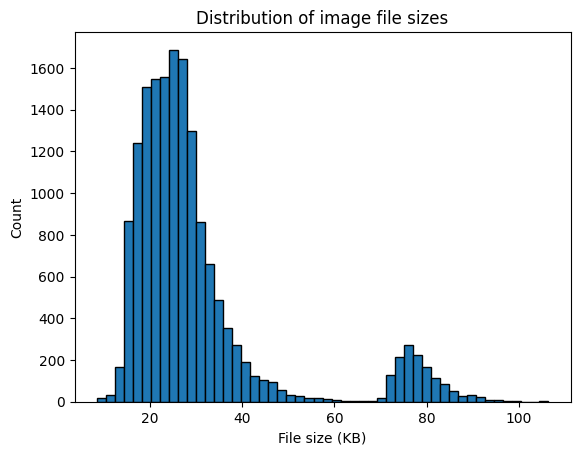

In [25]:
sizes = []

for folder_name in os.listdir(path):
    full_folder_path = os.path.join(path, folder_name)
    if os.path.isdir(full_folder_path):
        for file in os.listdir(full_folder_path):
            full_file_path = os.path.join(full_folder_path, file)
            if os.path.isfile(full_file_path):
                sizes.append(os.path.getsize(full_file_path) / 1024)  # KB

print(f"Min size: {min(sizes):.2f} KB")
print(f"Max size: {max(sizes):.2f} KB")
print(f"Avg size: {sum(sizes)/len(sizes):.2f} KB")

plt.hist(sizes, bins=50, edgecolor='black')
plt.xlabel("File size (KB)")
plt.ylabel("Count")
plt.title("Distribution of image file sizes")
plt.show()


In [26]:
dims = []

for folder_name in os.listdir(path):
    full_folder_path = os.path.join(path, folder_name)
    if os.path.isdir(full_folder_path):
        for file in os.listdir(full_folder_path):
            full_file_path = os.path.join(full_folder_path, file)
            try:
                with Image.open(full_file_path) as img:
                    dims.append(img.size)  # (width, height)
            except:
                pass  # bỏ qua file lỗi

# Đếm số lượng từng kích thước
dim_counter = Counter(dims)

# Chuyển sang DataFrame
df_dims = pd.DataFrame(
    dim_counter.items(),
    columns=["Resolution (Width, Height)", "Count"]
).sort_values(by="Count", ascending=False).reset_index(drop=True)

df_dims_30 = df_dims.head(25)


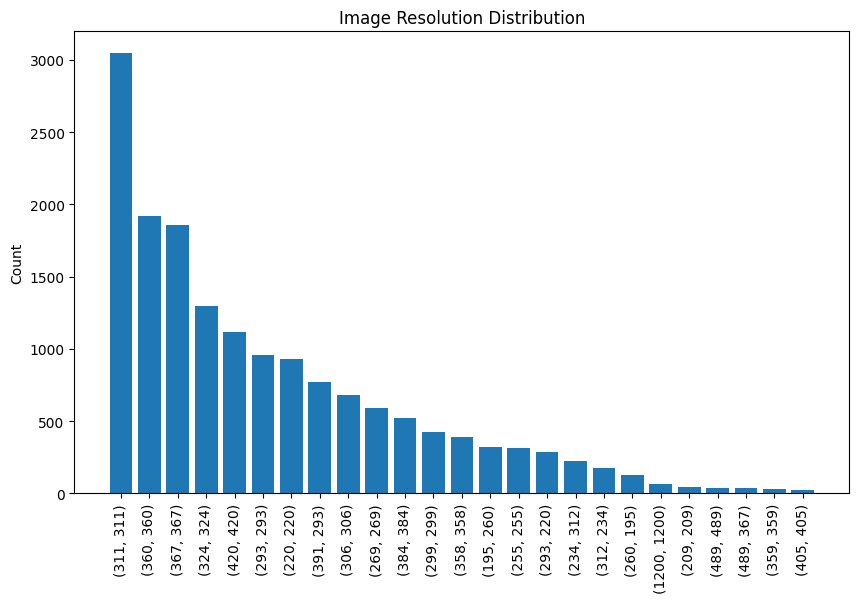

In [27]:
plt.figure(figsize=(10,6))
plt.bar(df_dims_30["Resolution (Width, Height)"].astype(str), df_dims_30["Count"])
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.title("Image Resolution Distribution")
plt.show()


In [28]:
path = "./Waste_Classification_Dataset"

corrupt_images = []

for folder_name in os.listdir(path):
    full_folder_path = os.path.join(path, folder_name)
    if os.path.isdir(full_folder_path):
        for file in os.listdir(full_folder_path):
            full_file_path = os.path.join(full_folder_path, file)
            try:
                with Image.open(full_file_path) as img:
                    img.verify()  # verify() chỉ check tính hợp lệ file, không load toàn bộ
            except Exception as e:
                corrupt_images.append(full_file_path)
                print(f"Corrupt image: {full_file_path} ({e})")

print(f"\nTotal corrupt images: {len(corrupt_images)}")



Total corrupt images: 0


In [29]:
low_quality = []

for folder_name in os.listdir(path):
    full_folder_path = os.path.join(path, folder_name)
    if os.path.isdir(full_folder_path):
        for file in os.listdir(full_folder_path):
            full_file_path = os.path.join(full_folder_path, file)
            try:
                with Image.open(full_file_path).convert("L") as img:  # grayscale
                    arr = np.array(img)
                    mean_val = arr.mean()
                    std_val = arr.std()

                    # Ảnh quá tối hoặc quá sáng
                    if mean_val < 20 or mean_val > 235:
                        low_quality.append((full_file_path, "Too dark/bright"))
                    
                    # Ảnh có độ tương phản thấp (mờ)
                    if std_val < 10:
                        low_quality.append((full_file_path, "Low contrast/blur"))
            except:
                pass

print(f"Found {len(low_quality)} low-quality images.")
# for img_path, reason in low_quality[:10]:
#     print(f"{img_path} -> {reason}")


Found 245 low-quality images.


In [30]:
import os
import shutil
import numpy as np
from PIL import Image

path = "./Waste_Classification_Dataset"
output_dir = "./low_quality_images"

# Tạo folder output nếu chưa tồn tại
os.makedirs(output_dir, exist_ok=True)

low_quality = []

for folder_name in os.listdir(path):
    full_folder_path = os.path.join(path, folder_name)
    if os.path.isdir(full_folder_path):
        for file in os.listdir(full_folder_path):
            full_file_path = os.path.join(full_folder_path, file)
            try:
                with Image.open(full_file_path).convert("L") as img:  # grayscale
                    arr = np.array(img)
                    mean_val = arr.mean()
                    std_val = arr.std()

                    # Ảnh quá tối hoặc quá sáng
                    if mean_val < 20 or mean_val > 235:
                        low_quality.append((full_file_path, "Too dark/bright"))
                    
                    # Ảnh có độ tương phản thấp (mờ)
                    if std_val < 10:
                        low_quality.append((full_file_path, "Low contrast/blur"))
            except:
                pass

print(f"Found {len(low_quality)} low-quality images.")

# Copy ảnh sang folder để review
for i, (img_path, reason) in enumerate(low_quality):
    filename = f"{i:04d}_" + os.path.basename(img_path)  # thêm index để tránh trùng tên
    dest_path = os.path.join(output_dir, filename)
    shutil.copy(img_path, dest_path)

print(f"Copied {len(low_quality)} low-quality images to {output_dir}")


Found 245 low-quality images.
Copied 245 low-quality images to ./low_quality_images


In [31]:
source_path = "Waste_Classification_Dataset"      
target_path = "dataset"      
split_dataset(source_path, target_path, train_ratio=0.8)

Class 'Metal': 1826 train, 457 val
Class 'Miscellaneous': 3539 train, 885 val
Class 'Paper': 2213 train, 554 val
Class 'Plastic': 5445 train, 1362 val


In [32]:
image_size = 224  # 224 or 128

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                         std=[0.5, 0.5, 0.5])
])


In [33]:
train_dir = "dataset/train"
val_dir = "dataset/val"

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

# --- tách val -> (val, test) 50/50 ---
n_val  = len(val_dataset)
n_half = n_val // 2
val_ds, test_ds = random_split(
    val_dataset,
    [n_half, n_val - n_half],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds,       batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds,      batch_size=32, shuffle=False)

print("Classes:", train_dataset.classes)
print(f"Val size: {len(val_ds)} | Test size: {len(test_ds)}")


Classes: ['Metal', 'Miscellaneous', 'Paper', 'Plastic']
Val size: 2941 | Test size: 2942


In [34]:
print("Classes:", train_dataset.classes)


Classes: ['Metal', 'Miscellaneous', 'Paper', 'Plastic']


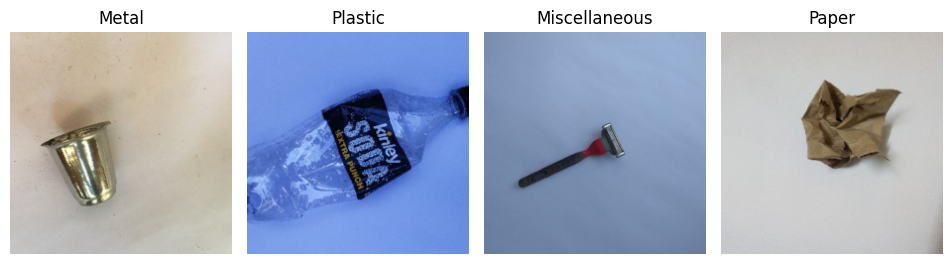

In [35]:
images, labels = next(iter(train_loader))
classes = train_dataset.classes

shown_classes = set()
plt.figure(figsize=(12, 6))
count = 0

for img, label in zip(images, labels):
    class_name = classes[label]

    if class_name not in shown_classes:
        shown_classes.add(class_name)
        img = img.permute(1, 2, 0) * 0.5 + 0.5  
        plt.subplot(2, 5, count + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
        count += 1

    if count == len(classes): 
        break

plt.tight_layout()
plt.show()

## **MODEL**

In [39]:
# ===== MODEL =====
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path   

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [41]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        def block(in_c, out_c, k=3, s=1, p=1):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=k, stride=s, padding=p, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )
        self.stem  = block(3, 32)
        self.l1    = nn.Sequential(block(32, 32), block(32, 64, s=2))
        self.l2    = nn.Sequential(block(64, 64), block(64, 128, s=2))
        self.l3    = nn.Sequential(block(128, 128), block(128, 256, s=2))
        self.extra = block(256, 256)
        self.drop  = nn.Dropout(0.25)
        self.head  = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.stem(x)
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.extra(x)
        x = self.drop(x)
        return self.head(x)

In [42]:
# Khởi tạo model với số class đúng
num_classes = len(train_dataset.classes)
model = SimpleCNN(num_classes=num_classes).to(device)


In [43]:
# ===== TRAINING =====
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
EPOCHS = 5

def accuracy(logits, y):
    return (logits.argmax(1) == y).float().mean().item()

@torch.no_grad()
def evaluate(loader):
    model.eval()
    tot_loss = tot_acc = n = 0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        b = x.size(0)
        tot_loss += loss.item()*b
        tot_acc  += accuracy(logits,y)*b
        n += b
    return tot_loss/n, tot_acc/n

def train_one_epoch():
    model.train()
    tot_loss = tot_acc = n = 0
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        optimizer.step()
        b = x.size(0)
        tot_loss += loss.item()*b
        tot_acc  += accuracy(logits,y)*b
        n += b
    return tot_loss/n, tot_acc/n


In [44]:
# ====== LOOP TRAIN + SAVE BEST ======
out_dir = Path("artifacts"); out_dir.mkdir(parents=True, exist_ok=True)   
ckpt_path = out_dir / "baseline_best.pt"                                  
best_acc, best_epoch = 0.0, 0

for e in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch()
    va_loss, va_acc = evaluate(val_loader)
    print(f"Epoch {e:02d} | train {tr_loss:.4f}/{tr_acc:.4f} | val {va_loss:.4f}/{va_acc:.4f}")

    # --- LƯU CHECKPOINT NẾU VAL_ACC TỐT HƠN ---
    if va_acc > best_acc:                     
        best_acc, best_epoch = va_acc, e
        torch.save({
            "epoch": e,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "classes": train_dataset.classes
        }, ckpt_path)
        print(f"  >> Saved best model (val_acc={best_acc:.4f})")


Epoch 01 | train 0.8562/0.6519 | val 0.7469/0.6848
  >> Saved best model (val_acc=0.6848)
Epoch 02 | train 0.6953/0.7234 | val 0.5975/0.7678
  >> Saved best model (val_acc=0.7678)
Epoch 03 | train 0.6313/0.7508 | val 0.5306/0.7919
  >> Saved best model (val_acc=0.7919)
Epoch 04 | train 0.5960/0.7655 | val 0.4981/0.8079
  >> Saved best model (val_acc=0.8079)
Epoch 05 | train 0.5577/0.7824 | val 0.4548/0.8188
  >> Saved best model (val_acc=0.8188)


In [45]:
# Load best checkpoint và test
ckpt = torch.load("artifacts/baseline_best.pt", map_location=device)
model.load_state_dict(ckpt["model_state"])
print(f"Loaded best model from epoch {ckpt['epoch']} (val_acc={best_acc:.4f})")

te_loss, te_acc = evaluate(test_loader)
print(f"Test acc: {te_acc:.4f}")


Loaded best model from epoch 5 (val_acc=0.8188)
Test acc: 0.8018
